In [1]:
from math import pi, sin, cos, log, tanh, sqrt, sinh, cosh, exp, floor, ceil
from scipy.special import voigt_profile
import math
import cmath
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

Kalpha = 1.540598
sig0 = 0.004
gamma0 = 0.011



In [218]:
class Fringe:
    def __init__(self, datadir='./xrd.csv', Xray = 1.540598, g_sig0 = 0.004, g_gamma0 = 0.011, nsigma = 2):
        txtdata = np.loadtxt(datadir, delimiter=',')
        self.x = np.array(txtdata[:,0])
        self.y = np.array(txtdata[:,1])
        self.x_step = round(100*(txtdata[1,0]-txtdata[0,0]))/100
        self.mem = {True : {'par' : {},
                            'std' : {},
                            'chisq' : 1e10},
                   False : {'par' : {},
                           'std' : {},
                           'chisq' : 1e10}}
        self.Xray = Xray
        self.g_sig0 = g_sig0
        self.g_gamma0 = g_gamma0
        self.nsigma = nsigma
        
    def f(self, two_theta, N0, par = None, need = {'sig1':True,'sig2':True,'sig3':True,'a0':True,'a1':True,'N1':True}, need_df = False, need_ddf = False):
        #print('f')
        sig1, sig2, sig3, a0, a1, N1 = par['sig1'], par['sig2'], par['sig3'], par['a0'], par['a1'], par['N1']
        th = two_theta*pi/360
        f = 0+0j
        df = {}
        ddf = {}
        for key, value in need.items():
            if value is True:
                if need_df is True:
                    df[key]=0+0j
                if need_ddf is True:
                    ddf[key]=0+0j
        
        if par is None:
            par = self.mem[False]['par']
        
        sum_inside = 0
        tanh_sum = 0
        sech_sum = 0
        sech_sum2 = 0
        tasech_sum = 0
        tasech_sum2 = 0
        for n in range(ceil(-self.nsigma*sig1), floor(N0 + self.nsigma*sig2)+1):
            sum_inside += 4j*pi*sin(th)/self.Xray * (a0 - a1*tanh((n-N1)/sig3)) 
            exp_val = cmath.exp(sum_inside)
            f_add = (tanh(n/sig1) - tanh((n-N0)/sig2)) * exp_val
            f += f_add
            
            if need['a0']:
                if need_df is True:
                    df['a0'] += 4j*pi*sin(th)/self.Xray * n * f_add
                if need_ddf is True:
                    ddf['a0'] += -16*(pi*sin(th)/self.Xray * n)**2 * f_add
            
            tanh_sum += tanh((n-N1)/sig3)
            if need['a1']:
                if need_df is True:
                    df['a1'] += -4j*pi*sin(th)/self.Xray * tanh_sum * f_add
                if need_ddf is True:
                    ddf['a1'] += -16*(pi*sin(th)/self.Xray * tanh_sum)**2 *f_add
            
            if n>=N1+self.nsigma*sig3 or n<=N1+self.nsigma*sig3:
                if need['N1']:
                    sech_sum += 1/ (cosh((n-N1)/sig3)**2)
                    if need_ddf:
                        tasech_sum += tanh((n-N1)/sig3)/ (cosh((n-N1)/sig3)**2)
                if need['sig3']:
                    sech_sum2 += (n-N1)/ (cosh((n-N1)/sig3)**2)
                    if need_ddf:
                        tasech_sum2 += ((n-N1)**2) * tanh((n-N1)/sig3)/ (cosh((n-N1)/sig3)**2)
            if need['N1']:
                if need_df:
                    df['N1'] += 4j*pi*sin(th)/self.Xray * a1/sig3 * sech_sum * f_add
                if need_ddf:
                    ddf['N1'] += 4j*pi*sin(th)/self.Xray * (4j*pi*sin(th)/self.Xray * (a1/sig3*sech_sum)**2 + a1/(sig3**2)*tasech_sum) *f_add
            if need['sig3']:
                if need_df:
                    df['sig3'] += 4j*pi*sin(th)/self.Xray * a1/sig3**2 * sech_sum2 *f_add
                    #print(a1, sech_sum2, f_add)
                if need_ddf:
                    ddf['sig3'] += 4j*pi*sin(th)/self.Xray * (4j*pi*sin(th)/self.Xray * (a1/sig3**2 * sech_sum2)**2 -2*a1/sig3**3 * sech_sum2 + a1/sig3**4 *tasech_sum2) *f_add
            
            if n <= self.nsigma * sig1 and need['sig1']:
                if need_df is True:
                    df['sig1'] += -n/((sig1 * cosh(n/sig1))**2) * exp_val
                if need_ddf is True:
                    ddf['sig1'] += (2*n/(sig1**3) - (n**2) / (sig1**4) * tanh(n/sig1) ) / (cosh(n/sig1)**2) *exp_val
            
            if n >= N0-self.nsigma*sig2 and need['sig2']:
                if need_df is True:
                    df['sig2'] += (n-N0)/(sig2**2) / (cosh((n-N0)/sig2)**2) * exp_val
                if need_ddf is True:
                    ddf['sig2'] += (-2*(n-N0)/(sig2**3) + ((n-N0)/(sig2**2) * tanh((n-N0)/sig2))) / (cosh((n-N0)/sig2)**2) * exp_val
        #print('df',df['sig3'])
        return [f,df,ddf]
    
    def F(self, two_theta, par = None, need = {'sig1':True,'sig2':True,'sig3':True, 'sigN':True, 'a0':True,'a1':True,'N': True,'N1':True},
          need_dF = False, need_ddF = False):
        #print('F')
        sig1, sig2, sig3, sigN, a0, a1, N, N1 = par['sig1'], par['sig2'], par['sig3'], par['sigN'], par['a0'], par['a1'], par['N'], par['N1']
        th = two_theta*pi/360
        F = 0
        dF = {}
        ddF = {}
        for key, value in need.items():
            if value is True:
                if need_dF is True:
                    dF[key]=0
                if need_ddF is True:
                    ddF[key]=0
        
        if par is None:
            par = self.mem[False]['par']
        
        normalize = sum([exp(-((N0-N)/sigN)**2/2) for N0 in range(ceil(N+self.nsigma*(sig2-sigN)), floor(N+self.nsigma*(sig2+sigN) +1))])
        for N0 in range(ceil(N+self.nsigma*(sig2-sigN)), floor(N+self.nsigma*(sig2+sigN) +1)):
            [f,df,ddf] = self.f(two_theta, N0, par, need, need_dF or need_ddF, need_ddF)
            f_add = (f*f.conjugate()).real * exp(-((N0-N)/sigN)**2/2)/normalize
            F += f_add
            if need_dF:
                for key, value in df.items():
                    dF[key] += 2* (f.conjugate()*value).real * exp(-((N0-N)/sigN)**2/2)/normalize
            if need_ddF:
                for key, value in ddf.items():
                    ddF[key] += 2* (f.conjugate()* value + df[key] * df[key].conjugate()).real * exp(-((N0-N)/sigN)**2/2)/normalize
            if need['N']:
                if need_dF:
                    dF['N'] += (N0-N)/sigN**2 * f_add
                if need_ddF:
                    ddF['N'] += (((N0-N)/sigN)**2 - 1)/sigN**2 * f_add
            if need['sigN']:
                if need_dF:
                    dF['sigN'] += (((N0-N)/sigN)**2 - 1)/sigN * f_add
                if need_ddF:
                    ddF['sigN'] += (2-5*((N0-N)/sigN)**2 + ((N0-N)/sigN)**4)/sigN**2 *f_add
        return [F,dF,ddF]
    
    def h(self, par = None, g_range = 0.1, g_scale = 0.001,
              need = {'sig1':True,'sig2':True,'sig3':True, 'sigN':True, 'a0':True,'a1':True,'N': True,'N1':True, 'A':True, 'b0':True, 'b1':True},
          need_dh = False, need_ddh = False):
        #print('h')
        A, b0, b1 = par['A'], par['b0'], par['b1']
        gx = np.arange(-g_range,g_range+g_scale, g_scale)
        gy = np.array([voigt_profile(i,sig0,gamma0) for i in gx])
        gy /= np.sum(gy)
        
        F_list = np.array([])
        dF_list = {}
        ddF_list = {}
        h = np.array([])
        dh = {}
        ddh = {}
        for key, value in need.items():
            if value is True:
                if need_dh is True:
                    dF_list[key]=np.array([])
                    dh[key]=np.array([])
                if need_ddh is True:
                    ddF_list[key]=np.array([])
                    ddh[key]=np.array([])
        
        if par is None:
            par = self.mem[False]['par']
            
        for two_theta in np.arange(min(self.x)-g_range, max(self.x)+g_range+g_scale, g_scale):
            [F,dF,ddF] = self.F(two_theta, par, need, need_dh or need_ddh, need_ddh)
            F_list = np.append(F_list, F)
            for key, value in need.items():
                if value is True and key != 'A' and key != 'b0' and key != 'b1':
                    if need_dh is True:
                        dF_list[key]=np.append(dF_list[key],dF[key])
                    if need_ddh is True:
                        ddF_list[key]=np.append(ddF_list[key], ddF[key])
        
        stride = round(self.x_step/g_scale)
        for i in range(len(self.x)):
            h = np.append(h, np.sum(gy*F_list[i*stride : i*stride+len(gy)])*A+b0+b1*self.x[i])
            for key, value in need.items():
                if value is True and key != 'A' and key != 'b0' and key != 'b1':
                    if need_dh is True:
                        dh[key] = np.append(dh[key], np.sum(gy*dF_list[key][i*stride : i*stride+len(gy)]))
                    if need_ddh is True:
                        ddh[key] = np.append(ddh[key], np.sum(gy*ddF_list[key][i*stride : i*stride+len(gy)]))
            if need['A']:
                if need_dh:
                    dh['A'] = np.append(dh['A'], np.sum(gy*F_list[i*stride : i*stride+len(gy)]))
                if need_ddh:
                    ddh['A'] = np.append(ddh['A'], 0)
            if need['b0']:
                if need_dh:
                    dh['b0'] = np.append(dh['b0'], 1)
                if need_ddh:
                    ddh['b0'] = np.append(ddh['b0'], 0)
            if need['b1']:
                if need_dh:
                    dh['b1'] = np.append(dh['b1'], self.x[i])
                if need_ddh:
                    ddh['b1'] = np.append(ddh['b1'],0)
        
        return [h, dh, ddh]
    
    def chisq(self, par = None, g_range = 0.1, g_scale = 0.001,
              need = {'sig1':True,'sig2':True,'sig3':True, 'sigN':True, 'a0':True,'a1':True,'N': True,'N1':True, 'A':True, 'b0':True, 'b1':True},
          need_dchisq = False, need_ddchisq = False):
        #print('chisq')
        chisq = 0+0j
        dchisq = {}
        ddchisq = {}
        if par is None:
            par = self.mem[False]['par']
            
        [h, dh, ddh] = self.h(par,g_range,g_scale, need, need_dchisq, need_ddchisq)
        
        chisq = np.sum((h-self.y)**2/self.y)
        for key, value in need.items():
            if value is True:
                if need_dchisq is True:
                    dchisq[key] = np.sum(2*(h-self.y)/self.y*dh[key])
                if need_ddchisq is True:
                    ddchisq[key] = np.sum(2/self.y*((h-self.y)*ddh[key]+dh[key]**2))

        return [chisq, dchisq, ddchisq]
    
    def plot(self, par=None, fast=True):
#         print('ploting')
        if fast:
            g_range = 0
            g_scale = 0.02
        else:
            g_range = 0.1
            g_scale = 0.001
        if par is None:
            par = self.mem[fast]['par']
        
        h, _, _ = self.h(par,g_range, g_scale)
        
        plt.figure()
        plt.plot(self.x, h)
        plt.scatter(self.x, self.y)
        plt.yscale('log')
        plt.show()
    
    def train(self, lr, par= None, fast=True, need = None,
              beta=0.9, nloops = None):
        
        if need is None:
            need = {'sig1':True,'sig2':True,'sig3':True, 'sigN':True, 'a0':True,'a1':True,'N': True,'N1':True, 'A':True, 'b0':True, 'b1':True}
        #print(need)
        if par is None:
            par = self.mem[fast]['par']
        v={}
#         print(need['N'])
        for key, value in need.items():
            if value is True:
                if lr[key] ==0:
                    need[key]=False
#         print(need['N'])
        for key, value in need.items():
            if value is True:
                v[key] = 0
        if fast:
            if nloops is None:
                nloops = 50
            g_range = 0
            g_scale = 0.02
        else:
            if nloops is None:
                nloops = 10
            g_range = 0.1
            g_scale = 0.001
        
        cnt = 0
        chisq_list = []
#         print(need['N'])
        while True:
            for epoch in range(nloops):
                #print(epoch, nloops)
                cnt+=1
                if epoch == nloops-1:
                    [chisq, dchisq, ddchisq] = self.chisq(par, g_range, g_scale, need,True, True)
                else:
                    [chisq, dchisq, _] = self.chisq(par, g_range, g_scale, need,True, False)
                
                chisq_list.append(chisq)
                
                if chisq < self.mem[fast]['chisq']:
                    self.mem[fast]['chisq'] = chisq
                    self.mem[fast]['par'] = par.copy()
                    if epoch == nloops-1:
                        for key, value in need.items():
                            if value and ddchisq[key] >0:
                                self.mem[fast]['std'][key] = sqrt(2/ddchisq[key])
                
                if (nloops<10 or epoch % (nloops//10) == 0) and epoch != nloops-1:
                    prt = f'({cnt})[{chisq : .2f}] '
                    for key, value in need.items():
                        if value:
                            prt += key +f':{par[key]: .4e}'+('+,' if dchisq[key]>=0 else '-,')
                    print(prt)
#                     print('plot')
                    self.plot(fast=fast)
                #print(dchisq['sig3'])
                for key, value in need.items():
                    if value:
                        v[key] = beta*v[key] + dchisq[key]
                        par[key] -= lr[key]*v[key]
            
            all_stable = True
            prt = f'({cnt})[{chisq : .2f}] '
            for key, value in need.items():
                if value:
                    prt += key +f':{par[key]: .4e}'+('+' if dchisq[key]>=0 else '-')
                    if ddchisq[key]>200*(dchisq[key]**2):
                        prt += 'S,'
                    else:
                        prt += 'U,'
                        all_stable = False
            print(prt)
            if all_stable:
                break
        
        plt.plot(range(len(chisq_list)), chisq_list)        

In [222]:
fringe = Fringe()

ploting


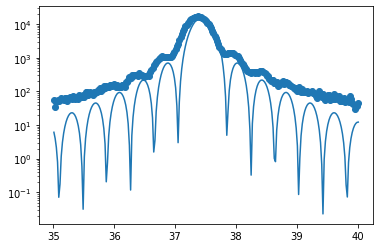

In [122]:
fringe.plot(par={'sig1':3,'sig2':3,'sig3':40, 'sigN':1, 'a0':2.4,'a1':0.001,'N': 95,'N1':50, 'A':0.4, 'b0':0, 'b1':0})

(1)[ 37906.87] a0: 2.4039e+00-,a1: 2.4629e-02+,N: 9.5000e+01-,


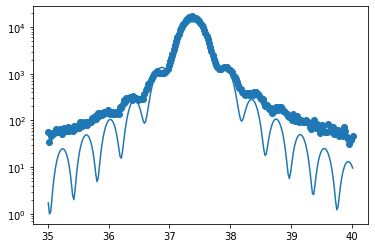

(6)[ 36320.91] a0: 2.4047e+00-,a1: 2.3593e-02+,N: 9.5060e+01-,


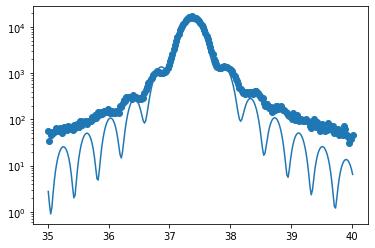

(11)[ 36623.55] a0: 2.4054e+00+,a1: 2.2410e-02-,N: 9.5195e+01-,


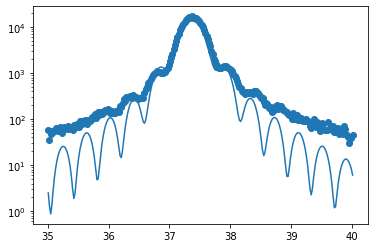

(16)[ 36369.35] a0: 2.4052e+00+,a1: 2.2535e-02-,N: 9.5372e+01-,


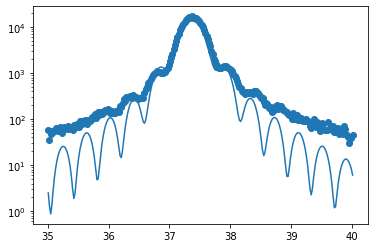

(21)[ 36255.31] a0: 2.4047e+00-,a1: 2.3281e-02+,N: 9.5569e+01-,


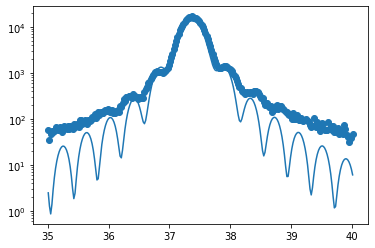

(26)[ 36299.29] a0: 2.4047e+00-,a1: 2.3519e-02+,N: 9.5775e+01-,


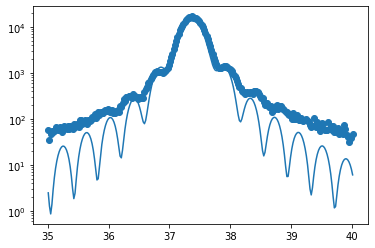

(31)[ 36191.69] a0: 2.4050e+00+,a1: 2.3172e-02+,N: 9.5982e+01-,


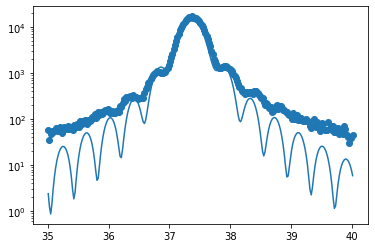

(36)[ 35684.19] a0: 2.4052e+00+,a1: 2.2734e-02-,N: 9.6193e+01-,


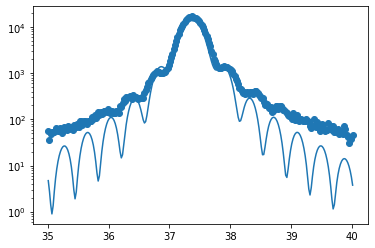

(41)[ 35698.92] a0: 2.4052e+00+,a1: 2.2612e-02-,N: 9.6411e+01-,


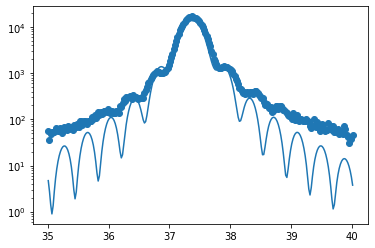

(46)[ 35672.16] a0: 2.4051e+00-,a1: 2.2831e-02-,N: 9.6628e+01-,


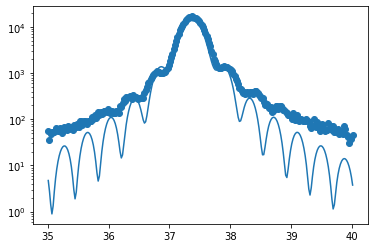

(50)[ 35680.79] a0: 2.4051e+00-U,a1: 2.2968e-02+U,N: 9.6842e+01-U,
(51)[ 35680.79] a0: 2.4051e+00-,a1: 2.2968e-02+,N: 9.6842e+01-,


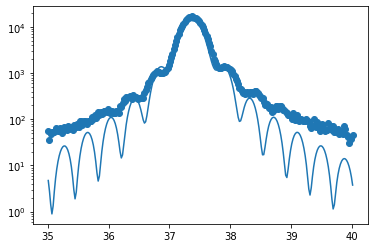

(56)[ 35331.77] a0: 2.4051e+00-,a1: 2.2858e-02+,N: 9.7050e+01-,


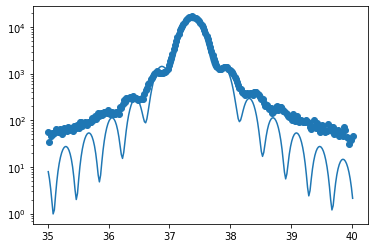

(61)[ 35271.86] a0: 2.4054e+00+,a1: 2.2486e-02-,N: 9.7261e+01-,


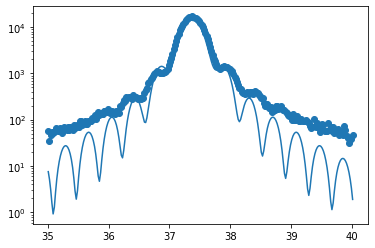

(66)[ 35294.24] a0: 2.4054e+00+,a1: 2.2399e-02-,N: 9.7474e+01-,


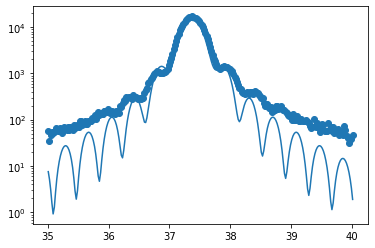

(71)[ 35266.34] a0: 2.4053e+00+,a1: 2.2607e-02+,N: 9.7684e+01-,


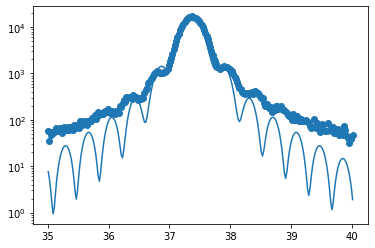

(76)[ 35274.70] a0: 2.4052e+00-,a1: 2.2696e-02+,N: 9.7889e+01-,


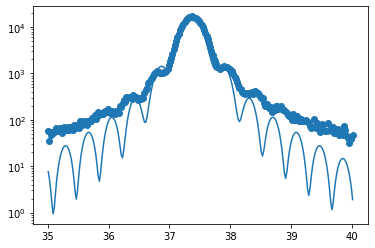

(81)[ 35018.28] a0: 2.4053e+00-,a1: 2.2519e-02+,N: 9.8088e+01-,


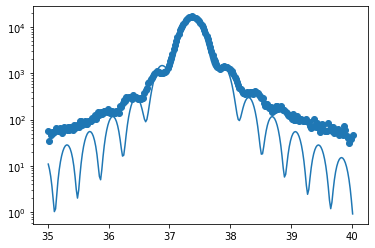

(86)[ 34983.87] a0: 2.4056e+00+,a1: 2.2167e-02-,N: 9.8291e+01-,


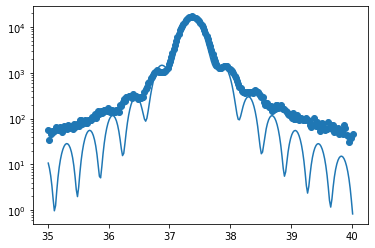

(91)[ 34992.72] a0: 2.4056e+00+,a1: 2.2210e-02-,N: 9.8495e+01-,


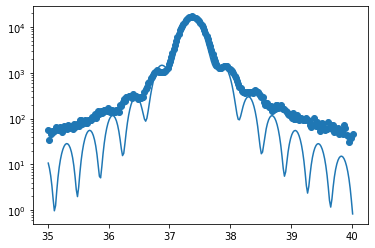

KeyboardInterrupt: 

In [224]:
fringe.train(lr={'sig1':0,'sig2':0,'sig3':0, 'sigN':0, 'a0':1e-11,'a1':1e-10,'N': 3e-9,'N1':0, 'A':0, 'b0':0, 'b1':0}, fast=True)